# This code is intended to fit and extract the HOM visibility from the UCSB sample QD emission, before and after frequency conversion.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
import os
from glob import glob1, glob

In [2]:
import matplotlib

matplotlib.rcParams.update({'font.size': 40})
matplotlib.rcParams['lines.linewidth'] = 5
matplotlib.rcParams['font.family']='serif'

params = {'legend.edgecolor': '0',
          'legend.borderaxespad': 1.5,
          'legend.fancybox': False,
          'legend.fontsize': 30.0,
          'legend.framealpha': 0.5,
          'legend.labelspacing': 0.3,
          'legend.markerscale': 1.0,
          'figure.figsize': (10, 8),
         'axes.labelsize': 40,
         'axes.titlesize': 40,
         'axes.linewidth': 3,
         'axes.xmargin': 0.03,
         'axes.ymargin': 0.03,
         'xtick.direction': 'in',
         'xtick.labelsize': 40,
         'xtick.major.pad': 10,
         'xtick.major.size': 10,
         'xtick.major.width': 3,
         'xtick.minor.pad': 10,
         'xtick.minor.size': 5,
         'xtick.minor.visible': True,
         'xtick.minor.width': 2,
         'xtick.top': True,
         'ytick.direction': 'in',
         'ytick.labelsize': 40,
         'ytick.major.pad': 10,
         'ytick.major.size': 10,
         'ytick.major.width': 3,
         'ytick.minor.pad': 10,
         'ytick.minor.size': 5,
         'ytick.minor.visible': True,
         'ytick.minor.width': 2,
         'ytick.right': True,}
plt.rcParams.update(params)

In [3]:
# functions to fit g2 and g2_hom
from scipy import signal


def convolve(dat, kernel):
    """simple convolution of two arrays"""
    npts = int(min(len(dat), len(kernel))/1.)
    pad = np.ones(npts)
    tmp = np.concatenate((pad*dat[0], dat, pad*dat[-1]))
#     out = np.convolve(tmp, kernel, mode='valid')
    out = signal.fftconvolve(tmp, kernel, mode='valid')
    noff = int((len(out) - npts) / 2)
    return (out[noff:])[:npts]

# def g2_nr(xdata,xc,t1,bck):
#     xdata =xdata-xc
#     return 1.0-bck*np.exp(-1.0*abs(xdata/t1))

def g2_nr(xdata,xc,t1,bck,amp,t2):
    xdata =xdata-xc
    return (1.0-bck*np.exp(-1.0*abs(xdata/t1)))*(1+amp*np.exp(-1*abs(xdata/t2)))


def convolve_g2_nr(xdata, xc,A,t1, bck,amp,t2,sig):
    g2_data =  g2_nr(xdata,xc,t1,bck,amp,t2)
    gau = np.exp(-((xdata)**2/(2*sig**2)))/(sig*np.sqrt(2*np.pi))
    res = convolve(g2_data,gau)
    out = res
    out = out/np.mean(out[-int(len(xdata)/100):])
    return A*(out)


def hom_eqn(xdata,ta,tb,xc,A,T1,T2,T3,amp ,bck,delT,V0):
#     tb = 0.5125
    rb = 1.-tb
    ra = 1.-ta
    xdata = xdata - xc
    D = ra*ta*(tb**2+rb**2) + rb*tb*(ra**2 + ta**2)
    cen = tb*rb*(ta**2+ra**2)*g2_nr(xdata,0,T1,bck,amp,T2)
    left = ta*ra*tb*tb*g2_nr(xdata-delT,0,T1,bck,amp,T2)
    right = ta*ra*rb*rb*g2_nr(xdata+delT, 0,T1,bck,amp,T2)
    gg1 = np.exp(-2*abs((xdata-xc)/T3)) 
    coh  = -2*ra*ta*rb*tb*V0*gg1
    return A*(cen+left+right+coh)/D

def convoluted_g2_HOM(xdata,ta,tb,xc,A,T1,T2,T3,amp, bck,delT,V0,sig):
    g2_data = hom_eqn(xdata,ta,tb,xc,A,T1,T2,T3,amp, bck,delT,V0)
    gau = np.exp(-((xdata-xc)**2/(2*sig**2)))/(sig*np.sqrt(2*np.pi))
    res = convolve(g2_data,gau)
    out = res
    out = out/np.mean(out[-int(len(xdata)/100):])
    return A*out


def visibility_normalisation_constant(lmfit_params,convoluted=False):
    '''
    This function attempts to solve the problem with normalising with the 
    
    '''
    if not convoluted:
        ta,tb,xc,A,T1,T2,T3,amp ,bck,delT,V0 = np.array(lmfit_params)
    else:
        Ahbt,Aper,Apar,ta,tb,t0,t1,t11,T1,T2,T3,amp, bck,delT,V0,sig  = np.array(lmfit_params)
#         ta,tb,xc,A,T1,T2,T3,amp, bck,delT,V0,sig = np.array(lmfit_params)

    rb = 1.-tb
    ra = 1.-ta
    xc = 0
    xdata = 0
    g1 = np.exp(-2*abs((xdata-xc)/T3)) 
    numerator = 2*ra*ta*rb*tb*g1
    cen = tb*rb*(ta**2+ra**2)*g2_nr(xdata,0,T1,bck,amp,T2)
    left = ta*ra*tb*tb*g2_nr(xdata-delT,0,T1,bck,amp,T2)
    right = ta*ra*rb*rb*g2_nr(xdata+delT, 0,T1,bck,amp,T2)
    denominator = cen+left+right
    return numerator/denominator


In [4]:
def g2_hom_eqn(xdata,Aper,Apar,ta,tb,t1,t11,T1,T2,T3,amp, bck,delT,V0,sig):
    perp = convoluted_g2_HOM(xdata,ta,tb,t1,Aper,T1,T2,T3,amp, bck,delT,0,sig)
    par = convoluted_g2_HOM(xdata,ta,tb,t11,Apar,T1,T2,T3,amp, bck,delT,V0,sig)
    return np.concatenate((par, perp))

def g2_all(xdata,Ahbt,Aper,Apar,ta,tb,t0,t1,t11,T1,T2,T3,amp, bck,delT,V0,sig):
    hbt = convolve_g2_nr(xdata, t0,Ahbt,T1, bck,amp,T2,sig)
    perp = convoluted_g2_HOM(xdata,ta,tb,t1,Aper,T1,T2,T3,amp, bck,delT,0,sig)
    par = convoluted_g2_HOM(xdata,ta,tb,t11,Apar,T1,T2,T3,amp, bck,delT,V0,sig)
    return np.concatenate((hbt,par, perp))

def g2_all_deconvolved(xdata,Ahbt,Aper,Apar,ta,tb,t0,t1,t11,T1,T2,T3,amp, bck,delT,V0,sig):
    hbt = g2_nr(xdata, t0,T1, bck,amp,T2)
    perp = hom_eqn(xdata,ta,tb,t1,Aper,T1,T2,T3,amp, bck,delT,0)
    par = hom_eqn(xdata,ta,tb,t11,Apar,T1,T2,T3,amp, bck,delT,V0)
    return np.concatenate((hbt,par, perp))

try:
    from fpi_functions import find_nearest
except:
    print ('fpi functions not found')
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx,array[idx]





In [5]:
directory  = r'D:\Dropbox (Heriot-Watt University Team)\RES_EPS_Quantum_Photonics_Lab\Experiments\QFC [Markus]\newDFGCharacterisation\08122020_DFG_G2data'
# directory  = r'C:\Users\ZakKoong\Dropbox (Heriot-Watt University Team)\RES_EPS_Quantum_Photonics_Lab\Experiments\QFC [Markus]\newDFGCharacterisation\08122020_DFG_G2data'
flst = glob1(directory,"**.npy")

In [6]:
def load_cwdata_npy(filename,normalized=False):
    data = np.load(filename)
    if not normalized:
        return data[:,0],data[:,1]
    else:
        return data[:,0],data[:,1]/data[:,1][-100:].mean()
filenamehbt = os.path.join(directory,flst[3])
filenamehoms = os.path.join(directory,flst[5])
filenamehomp = os.path.join(directory,flst[4])
delayhbt,coinhbt = load_cwdata_npy(filenamehbt,normalized=True)
delayhoms,coinhoms = load_cwdata_npy(filenamehoms,normalized=True)
delayhomp,coinhomp = load_cwdata_npy(filenamehomp,normalized=True)

C:\ProgramData\Miniconda3\lib\site-packages\asteval\astutils.py:226: RuntimeWarning: divide by zero encountered in double_scalars
  ast.Div: lambda a, b: a / b,


[[Model]]
    Model(convolve_g2_nr)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 624999
    # variables        = 5
    chi-square         = 485.924027
    reduced chi-square = 7.7749e-04
    Akaike info crit   = -4474640.99
    Bayesian info crit = -4474584.26
[[Variables]]
    xc:  -0.01880792 +/- 0.00178103 (9.47%) (init = -0)
    A:    1 (fixed)
    t1:   0.29927475 +/- 0.00299971 (1.00%) (init = 0.3)
    bck:  1 (fixed)
    amp:  0.03788905 +/- 1.3887e-04 (0.37%) (init = 0.03735753)
    t2:   2527.31245 +/- 17.4782198 (0.69%) (init = 2655)
    sig:  0.04452246 +/- 0.00292391 (6.57%) (init = 0.07)
    g20:  0.00000000 +/- 0.00000000  == '1.-bck'
    SBR:         inf +/-        nan (nan%) == '1/(1-sqrt(1-g20))'
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, t2) = -0.657
    C(xc, sig) =  0.161


(-10.0, 10.0)

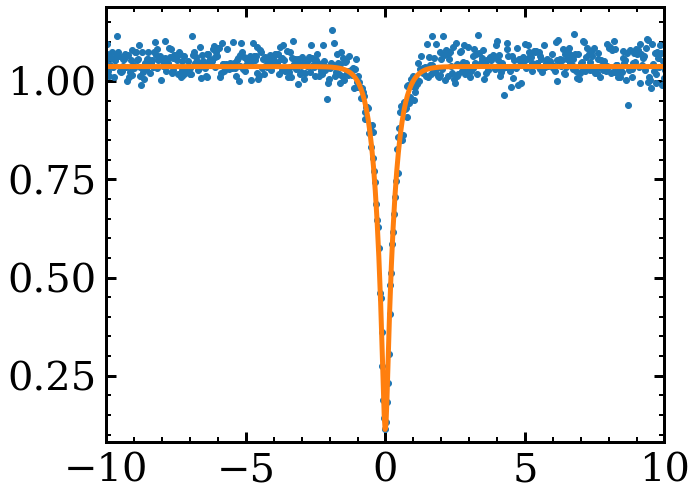

In [7]:
# apply for nr excitation
model = Model(convolve_g2_nr)
model.set_param_hint('g20', expr='1.-bck')
model.set_param_hint('SBR', expr='1/(1-sqrt(1-g20))')
params = model.make_params(xc=-21.2*0,A=1,sig=0.07, t1 = 0.3,amp=0.03735753,t2=2655, bck=1)
# params['sig'].set(vary=False)
params['bck'].set(min=0,max=1,vary=False)
params['t1'].set(vary=  True)
params['amp'].set(vary=not False)
params['t2'].set(vary= not False)
# params['xc'].set(min=-10,max=10,vary=False)
params['A'].set(vary=False)
start = find_nearest(delayhbt,-10000)[0]
end = find_nearest(delayhbt,10000)[0]
result = model.fit(coinhbt[start:end],params,xdata = delayhbt[start:end],weights=1/np.sqrt(coinhbt[start:end]),nan_policy='omit')
print(result.fit_report())
plt.plot(delayhbt[start:end],coinhbt[start:end],'o')
plt.plot(delayhbt[start:end],model.eval(result.params,xdata=delayhbt[start:end]))
plt.xlim([-10,10])

In [8]:
# fit all
mod = Model(g2_all)
model.set_param_hint('g20', expr='1.-bck')
params = mod.make_params(Ahbt=1,Aper=1,Apar=1,ta=0.5,tb=0.5,t0=result.params['xc'].value,t1=result.params['xc'].value,t11=result.params['xc'].value,T1=result.params['t1'].value,T2=result.params['t2'].value, 
                         T3=result.params['t2'].value*1,amp=result.params['amp'].value,
                         bck=result.params['bck'].value,
                         delT = 12.5,
                         V0=1,
                         sig = result.params['sig'].value)

params['Ahbt'].set(vary=False)
params['Aper'].set(vary=False)
params['Apar'].set(vary=not False)
params['ta'].set(vary=False)
params['tb'].set(vary=False)
params['t0'].set(vary=False)
params['t1'].set(vary=not False)
params['t11'].set(expr='t1')
params['T1'].set(vary=False)
params['T2'].set(vary=False)
params['bck'].set(vary=False)
params['amp'].set(vary=False)
params['sig'].set(vary=False)
params['V0'].set(min=0,max=1,vary=not False)
params['delT'].set(min=0,max=30)
params['T3'].set(min=0,max=1)
_y = np.concatenate([coinhbt[start:end],coinhoms[start:end],coinhomp[start:end]])
resultall = mod.fit(_y,params,xdata=delayhbt[start:end])


[[Model]]
    Model(g2_all)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1874997
    # variables        = 5
    chi-square         = 1403.62680
    reduced chi-square = 7.4860e-04
    Akaike info crit   = -13494911.3
    Bayesian info crit = -13494849.1
[[Variables]]
    Ahbt:  1 (fixed)
    Aper:  1 (fixed)
    Apar:  1.00499433 +/- 3.4313e-05 (0.00%) (init = 1)
    ta:    0.5 (fixed)
    tb:    0.5 (fixed)
    t0:   -0.01880792 (fixed)
    t1:   -0.00722898 +/- 0.00118625 (16.41%) (init = -0.01880792)
    t11:  -0.00722898 +/- 0.00118625 (16.41%) == 't1'
    T1:    0.2992748 (fixed)
    T2:    2527.312 (fixed)
    T3:    0.48397814 +/- 0.02763669 (5.71%) (init = 1)
    amp:   0.03788905 (fixed)
    bck:   1 (fixed)
    delT:  12.4379008 +/- 0.00603310 (0.05%) (init = 12.5)
    V0:    0.73864105 +/- 0.02921869 (3.96%) (init = 1)
    sig:   0.04452246 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(T3, V0)

(-5.0, 5.0)

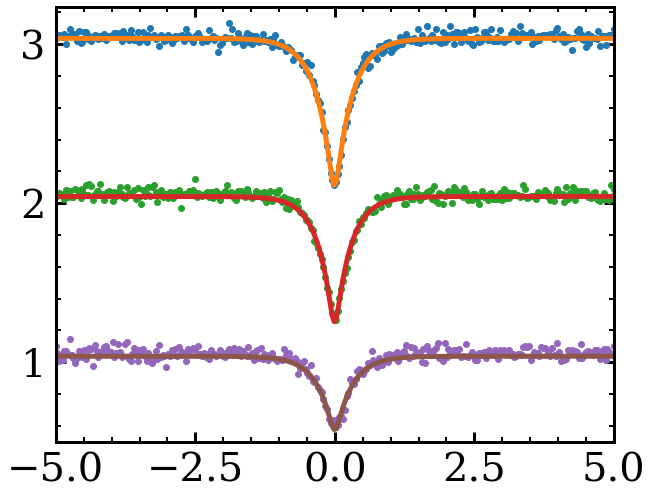

In [9]:
print (resultall.fit_report())
fitresult = mod.eval(resultall.params,xdata=delayhbt[start:end])
length = len(delayhbt[start:end])
hbt = fitresult[:length]
homs = fitresult[length:2*length]
homp = fitresult[2*length:]

dummyx = np.linspace(-30,30,50000)

fitresultdec = Model(g2_all_deconvolved).eval(resultall.params,xdata=dummyx)
length2 = len(dummyx)
hbtdec = fitresultdec[:length2]
homsdec = fitresultdec[length2:2*length2]
hompdec = fitresultdec[2*length2:]

plt.plot(delayhbt[start:end],coinhbt[start:end]+2,'o')
plt.plot(delayhbt[start:end],hbt+2,'-')


plt.plot(delayhoms[start:end],coinhoms[start:end]+1,'o')
plt.plot(delayhbt[start:end],homs+1,'-')

plt.plot(delayhomp[start:end],coinhomp[start:end],'o')
plt.plot(delayhbt[start:end],homp,'-')

plt.xlim([-5,5])

## display data with deconvolved data

(0.0, 1.2)

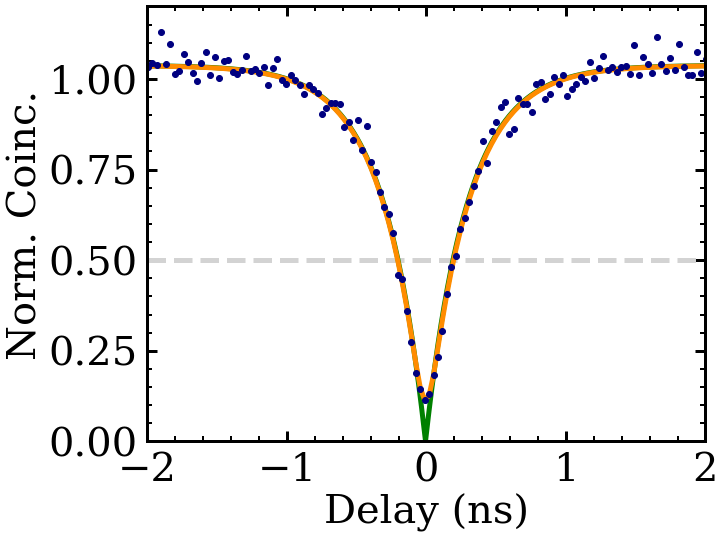

In [10]:
f = plt.figure()
ax = f.add_subplot(111)
ax.axhline(y=0.5,ls='--',color='lightgrey')

ax.plot(dummyx+0.012,Model(g2_nr).eval(result.params,xdata=dummyx),ls='-',color='green')
ax.plot(delayhbt[start:end],model.eval(result.params,xdata=delayhbt[start:end]),color='darkorange')
ax.plot(delayhbt[start:end],coinhbt[start:end],'o',color='navy')
ax.set_ylabel('Norm. Coinc.')
ax.set_xlabel('Delay (ns)')
ax.set_xlim([-2,2])
ax.set_ylim([0,1.2])

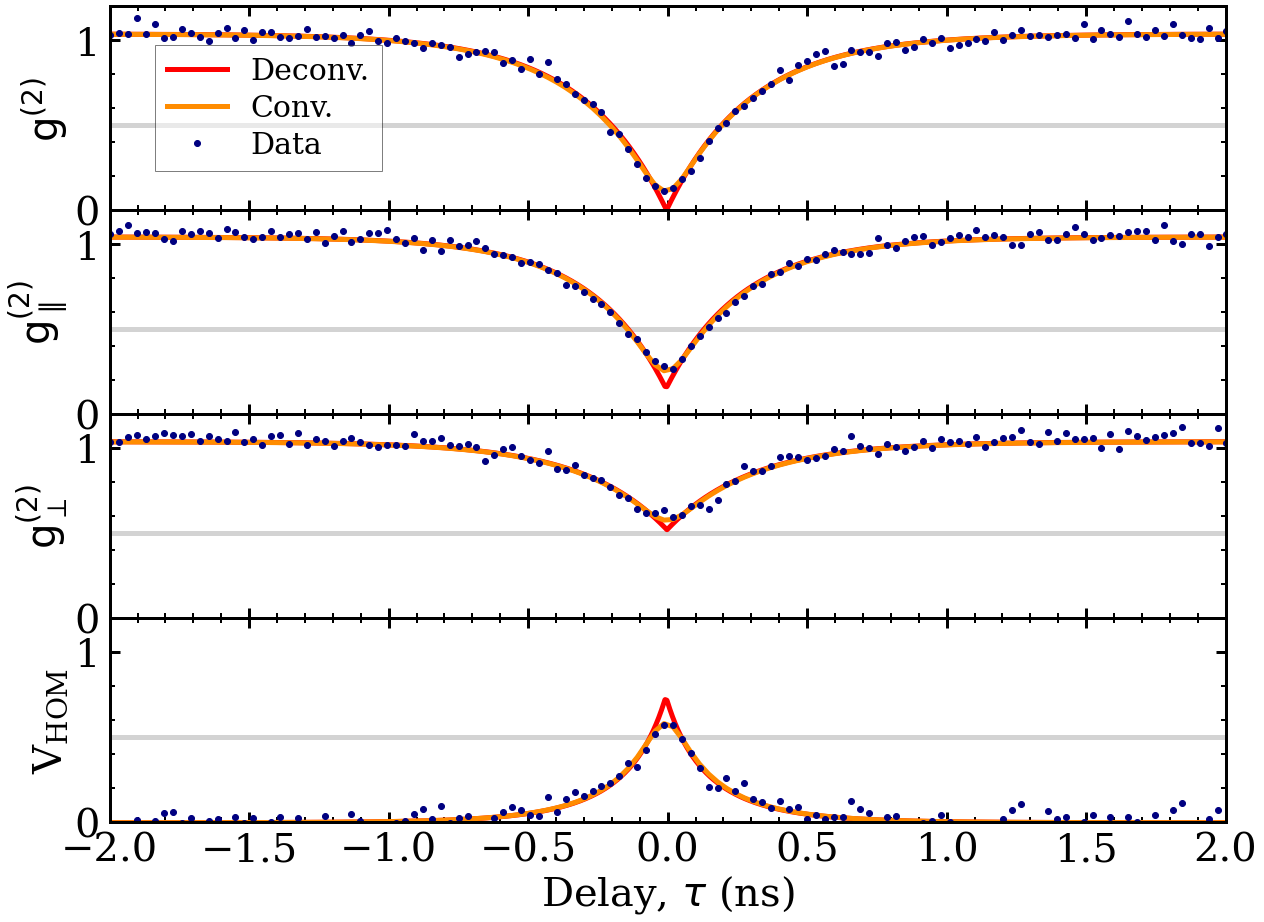

In [11]:
f = plt.figure(figsize=(20,15))
ax0 =f.add_subplot(411)
ax =f.add_subplot(412)
ax1 =f.add_subplot(413)
ax2 = f.add_subplot(414)
f.subplots_adjust(hspace=0, wspace=0)


vnorm = visibility_normalisation_constant(resultall.params,convoluted=True)
# # vnorm  =0.5

# vhomf = (perf-parf)/perf/vnorm
# g20 = resulth.params['g20'].value
# g20_err = resulth.params['g20'].stderr


# ctw = np.sum(vhom[find_nearest(delays[start:end],-5)[0]:find_nearest(delays[start:end],5)[0]])*np.diff(delayp)[0]
# print ('CTW = %.3f ns'%ctw)

ax0.axhline(y=0.5,ls='-',color='lightgrey')
ax0.plot(dummyx+0.015,hbtdec,ls='-',color='red',label='Deconv.')
ax0.plot(delayhbt[start:end],model.eval(result.params,xdata=delayhbt[start:end]),color='darkorange',label='Conv.')
ax0.plot(delayhbt[start:end],coinhbt[start:end],'o',color='navy',label='Data')
ax0.legend(loc='center left')


ax.axhline(y=0.5,ls='-',color='lightgrey')
ax1.axhline(y=0.5,ls='-',color='lightgrey')
ax2.axhline(y=0.5,ls='-',color='lightgrey')

ax.plot(dummyx+0.005,homsdec,ls='-',color='red')
ax.plot(delayhbt[start:end],homs,'-',color='darkorange')
ax.plot(delayhbt[start:end],coinhoms[start:end],'o',color='navy')

ax1.plot(dummyx+0.005,hompdec,ls='-',color='red')
ax1.plot(delayhbt[start:end],homp,'-',color='darkorange')
ax1.plot(delayhbt[start:end],coinhomp[start:end],'o',color='navy')

vhomdec =  (hompdec-homsdec)/hompdec/vnorm
vhomf = (homp-homs)/homp/vnorm
vhom = (coinhomp[start:end]-coinhoms[start:end])/coinhomp[start:end]/vnorm
ax2.plot(dummyx+0.005,vhomdec,ls='-',color='red')
ax2.plot(delayhbt[start:end],vhomf,'-',color='darkorange')
ax2.plot(delayhbt[start:end],vhom,'o',color='navy')

ax1.set_ylabel(r'$\rm g^{(2)}_\perp$')
ax0.set_ylabel(r'$\rm g^{(2)}$')
ax.set_ylabel(r'$\rm g^{(2)}_\parallel$')
ax2.set_ylabel(r'$\mathregular{V_{HOM}}$')
ax2.set_xlabel(r'Delay, $\tau$ (ns)')
ax.set_ylim([0,1.2])
ax0.set_ylim([0,1.2])
ax0.set_xticklabels([])
ax.set_xticklabels([])
ax1.set_xticklabels([])
ax1.set_ylim([0,1.2])
ax2.set_ylim([0,1.2])

# _xlim = [-20,20]
_xlim = [-2,2]
ax0.set_xlim(_xlim)
ax1.set_xlim(_xlim)
ax2.set_xlim(_xlim)
ax.set_xlim(_xlim)

g20 = result.params['g20'].value
g20_err = result.params['g20'].stderr

# ax0.text(5,0.55,r'$\rm g^{(2)}(0)=%.3f\,(%.0f)$'%(g20,g20_err*1000))
# ax2.text(-18,0.8,r'CTW = %.3f ns'%(ctw))
# ax2.text(5,0.8,r'$\mathregular{V_{HOM}}=%.2f\,(%.0f)$'%(resultall.params['V0'].value,resultall.params['V0'].stderr*1e2))
# f.savefig(filenamehbt[:-4]+'_summary_short.png',dpi=100,bbox_inches='tight',facecolor='white')

# After dfg

In [17]:
filenamehbt = os.path.join(directory,flst[0])
filenamehoms = os.path.join(directory,flst[2])
filenamehomp = os.path.join(directory,flst[1])
filenamehbtlaser = os.path.join(directory,"09122020_dfgRF_942p5nm_0p1nmBW_2p76V_0p003nA_JustCWLaserHBT_32ps.npy")
filenamehbtpulsedlaser = os.path.join(directory,"09122020_dfgRF_942p5nm_0p1nmBW_2p76V_0p003nA_JustLaserHBT_32ps.npy")
delayhbtpulsedlaser,coinhbtpulsedlaser = load_cwdata_npy(filenamehbtpulsedlaser,normalized=not True)
delayhbtlaser,coinhbtlaser = load_cwdata_npy(filenamehbtlaser,normalized=True)
delayhbt,coinhbt = load_cwdata_npy(filenamehbt,normalized=True)
delayhoms,coinhoms = load_cwdata_npy(filenamehoms,normalized=True)
delayhomp,coinhomp = load_cwdata_npy(filenamehomp,normalized=True)

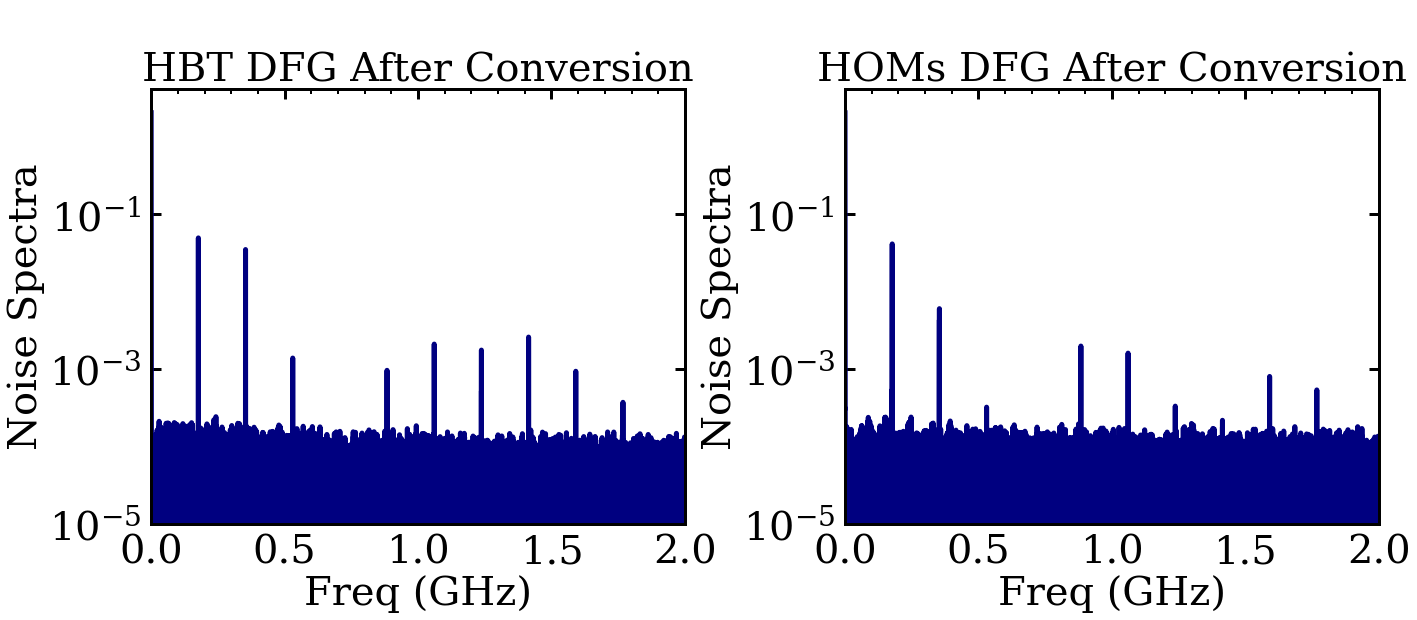

In [18]:
from fourier import fourier
from Detect_peaks import detect_peaks

f = plt.figure(figsize=(22,8))
f.subplots_adjust(wspace=0.3)
ax = f.add_subplot(121)
ax1 = f.add_subplot(122)
def plot_fourier(ax,delayhbt,coinhbt,title=None):
    
    freq, noise = fourier(delayhbt,coinhbt)
    noise = abs(noise)
    idx = detect_peaks(noise,mph=1e-3,mpd=50)
    if float(freq[idx[0]])<1e-2:
        print(float(freq[idx[0]]))
        idx = idx[1:]
#     print(freq[idx],np.diff(freq[idx]))
    ax.semilogy(freq,noise,color='navy')
    for j in range(len(idx)):
        if j==0:
            ax.annotate('%.3f GHz'%(freq[idx[j]]), xy=(freq[idx[j]], 5), xytext=(freq[idx[j]] +.1, 20),
                arrowprops=dict(facecolor='black', shrink=0.05),
                )

    ax.set_xlim([0,2])
    ax.set_ylim(bottom=1e-5)
    ax.set_xlabel('Freq (GHz)')
    ax.set_ylabel('Noise Spectra')
    if title is not None:
        ax.set_title('%s'%(title))
plot_fourier(ax,delayhbt,coinhbt,title='HBT DFG After Conversion')
plot_fourier(ax1,delayhoms,coinhoms,title='HOMs DFG After Conversion')
from fourier import fourier
freq, noise = fourier(delayhbt,coinhbt)
idx = detect_peaks(noise,mph=1e-3,mpd=50)
# f.savefig(filenamehoms[:-4]+'_noise_spectra_comparison.png',dpi=100,bbox_inches='tight',facecolor='white')

Text(0, 0.5, 'Noise Spectra')

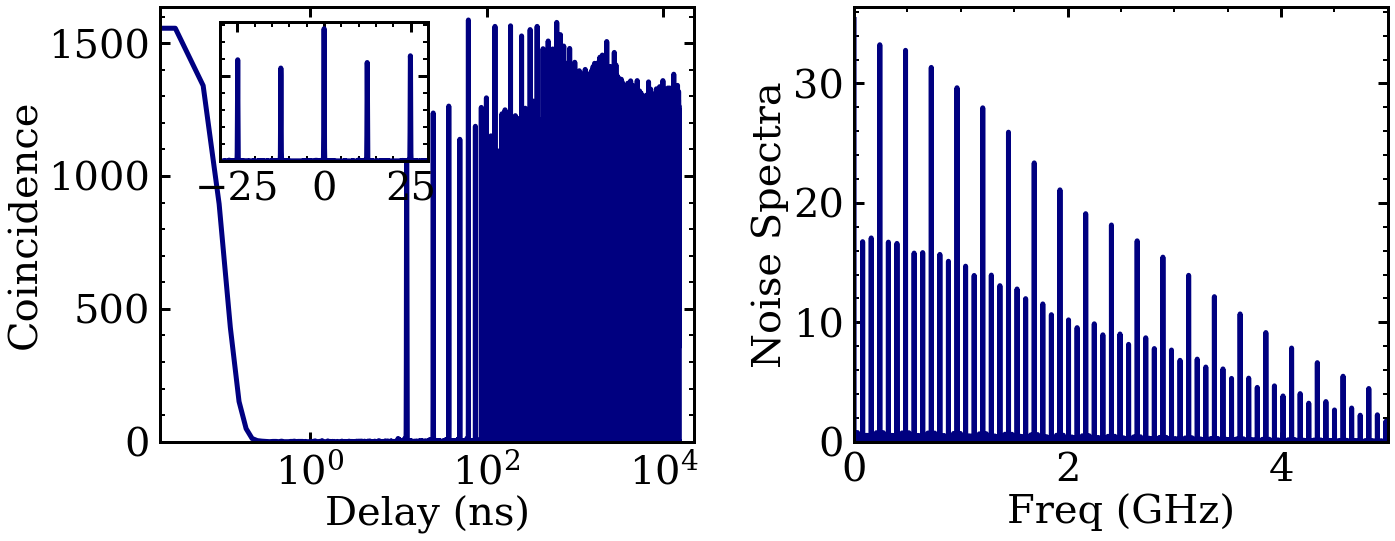

In [19]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset) 
f = plt.figure(figsize=(22,8))
f.subplots_adjust(wspace=0.3)
ax = f.add_subplot(121)
axins = inset_axes(ax, "30%", "40%",
                      bbox_to_anchor=(-0.77, 0.2, 1.3, 0.8),
                      bbox_transform=ax.transAxes) # zoom = 6
axins.plot(delayhbtpulsedlaser+0.035,coinhbtpulsedlaser,color='navy')
ax.semilogx(delayhbtpulsedlaser+0.035,coinhbtpulsedlaser,color='navy')
ax.set_xlabel('Delay (ns)')
ax.set_ylabel('Coincidence')
axins.set_xlim([-30,30])
axins.set_yticklabels([])
axins.set_ylim(bottom=0)
ax.set_ylim(bottom=0)
ax1 = f.add_subplot(122)
freq, noise = fourier(delayhbtpulsedlaser,coinhbtpulsedlaser)

ax1.plot(freq,abs(noise),color='navy')
ax1.set_xlim([0,5])
ax1.set_ylim(bottom=0)
ax1.set_xlabel('Freq (GHz)')
ax1.set_ylabel('Noise Spectra')
# f.savefig(filenamehbtpulsedlaser[:-4]+'_noise_spectra_combined.png',dpi=100,bbox_inches='tight',facecolor='white')

[[Model]]
    Model(g2_nr_osc_cov)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 187
    # data points      = 31250
    # variables        = 8
    chi-square         = 23.8238771
    reduced chi-square = 7.6256e-04
    Akaike info crit   = -224330.448
    Bayesian info crit = -224263.650
[[Variables]]
    Amp:    1.04486009 +/- 2.3500e-04 (0.02%) (init = 1)
    xc:    -0.01880792 (fixed)
    t1:     0.2992748 (fixed)
    bck:    1.18656533 +/- 0.00865564 (0.73%) (init = 1)
    amp:    0.03788905 (fixed)
    t2:     2527.312 (fixed)
    sig:    0.03 (fixed)
    amp1:   0.00344398 +/- 2.0772e-04 (6.03%) (init = 0.1977665)
    amp2:   0.09583128 +/- 2.1283e-04 (0.22%) (init = 0.9624725)
    amp3:   0.12882290 +/- 2.1344e-04 (0.17%) (init = 0.4186421)
    freq1:  0.00110411 +/- 6.4376e-05 (5.83%) (init = 6.66666e-05)
    freq2:  0.17684561 +/- 1.2151e-06 (0.00%) (init = 0.1768665)
    freq3:  0.35368927 +/- 9.0431e-07 (0.00%) (init = 0.3536663)
    g20:   -0.

(-10.0, 10.0)

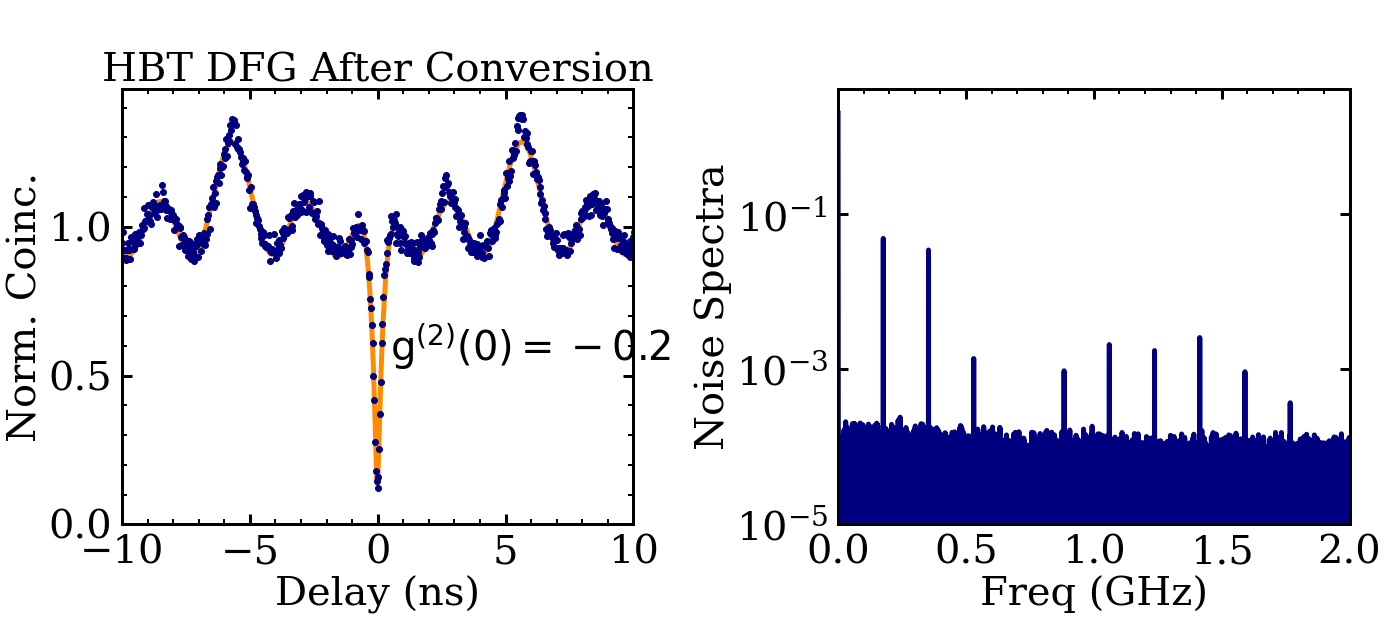

In [20]:
dummyx2 = np.linspace(-100,100,30000)
start1 = find_nearest(delayhbt,-500)[0]
end1 = find_nearest(delayhbt,500)[0]

def g2_nr_osc(xdata,Amp,xc,t1,bck,amp,t2,amp1,amp2,amp3,freq1,freq2,freq3):
    xdata1 = xdata - xc
    return Amp*(g2_nr(xdata,xc,t1,bck,amp,t2)*1 + amp1*np.cos(2*np.pi*freq1*xdata1) + amp2*np.cos(2*np.pi*freq2*xdata1) +  amp3*np.cos(2*np.pi*freq3*xdata1))

def g2_nr_osc_laser(xdata,Amp,xc,t1,bck,amp,t2,amp1,amp2,amp3,freq1,freq2,freq3):
    xdata1 = xdata - xc
    return Amp*(g2_nr(xdata,xc,t1,bck,amp,t2)*0 +1 + amp1*np.cos(2*np.pi*freq1*xdata1) + amp2*np.cos(2*np.pi*freq2*xdata1) +  amp3*np.cos(2*np.pi*freq3*xdata1))

def g2_nr_osc_cov(xdata,Amp,xc,t1,bck,amp,t2,sig,amp1,amp2,amp3,freq1,freq2,freq3):
    xdata1 = xdata - xc
    return Amp*(convolve_g2_nr(xdata,xc,1,t1,bck,amp,t2,sig)*1 + amp1*np.cos(2*np.pi*freq1*xdata1) + amp2*np.cos(2*np.pi*freq2*xdata1) +  amp3*np.cos(2*np.pi*freq3*xdata1))
# convolve_g2_nr
mod1 = Model(g2_nr_osc_cov)
mod1.set_param_hint('g20', expr='1.-bck')
params = mod1.make_params(Amp=1,xc=result.params['xc'].value, t1=result.params['t1'].value, bck=result.params['bck'].value, 
                         amp=result.params['amp'].value, t2=result.params['t2'].value,sig=0.03,
                        amp1=2*noise[idx[0]],amp2=2*noise[idx[1]],amp3=2*noise[idx[2]],freq1=freq[idx[0]],freq2=freq[idx[1]],freq3=freq[idx[2]])
params['Amp'].set(vary=True)
params['xc'].set(vary=False)
params['t1'].set(vary=False)
# params['bck'].set(vary=False)
params['sig'].set(min=0,max=1,vary=False)
params['amp'].set(vary=False)
params['t2'].set(vary=False)
params['amp1'].set(vary=not False)
params['amp2'].set(vary=not False)
params['amp3'].set(vary=not False)
params['freq1'].set(vary=not False)
params['freq2'].set(vary=not False)
params['freq3'].set(vary=not False)

res_osc = mod1.fit(coinhbt[start1:end1],params,xdata=delayhbt[start1:end1])


f = plt.figure(figsize=(22,8))
f.subplots_adjust(wspace=0.4)
ax = f.add_subplot(121)
ax1 = f.add_subplot(122)
plot_fourier(ax1,delayhbt,coinhbt)

ax.plot(dummyx2,mod1.eval(res_osc.params,xdata=dummyx2),'-',color='darkorange',label='fit')
ax.plot(delayhbt[start1:end1],coinhbt[start1:end1],'o',color='navy',label='data')
ax.set_xlabel('Delay (ns)')
ax.set_ylabel('Norm. Coinc.')
ax.text(0.5,0.55,r'$\rm g^{(2)}(0)=%.1f$'%(1-res_osc.params['bck'].value,))
print (res_osc.fit_report())
ax.set_title('HBT DFG After Conversion')
ax.set_ylim(bottom=0)
ax.set_xlim([-10,10])

# f.savefig(filenamehbt[:-4]+'_noise_spectra_combined.png',dpi=100,bbox_inches='tight',facecolor='white')

## Compare CW laser vs QD signal

In [21]:
mod2 = Model(g2_nr_osc_laser)
mod2.set_param_hint('g20', expr='1.-bck')
params = mod2.make_params(Amp=1,xc=result.params['xc'].value, t1=result.params['t1'].value, bck=result.params['bck'].value, 
                         amp=result.params['amp'].value, t2=result.params['t2'].value,sig=0.03,
                        amp1=2*noise[idx[0]],amp2=2*noise[idx[1]],amp3=2*noise[idx[2]],freq1=freq[idx[0]],freq2=freq[idx[1]],freq3=freq[idx[2]])
params['Amp'].set(vary=True)
params['xc'].set(vary=False)
params['t1'].set(vary=False)
params['bck'].set(vary=False)

params['amp'].set(vary=False)
params['t2'].set(vary=False)
params['amp1'].set(vary=not False)
params['amp2'].set(vary=not False)
params['amp3'].set(vary=not False)
params['freq1'].set(vary=not False)
params['freq2'].set(vary=not False)
params['freq3'].set(vary=not False)
res_osc_laser = mod2.fit(coinhbtlaser[start1:end1],params,xdata=delayhbtlaser[start1:end1])

(-10.0, 10.0)

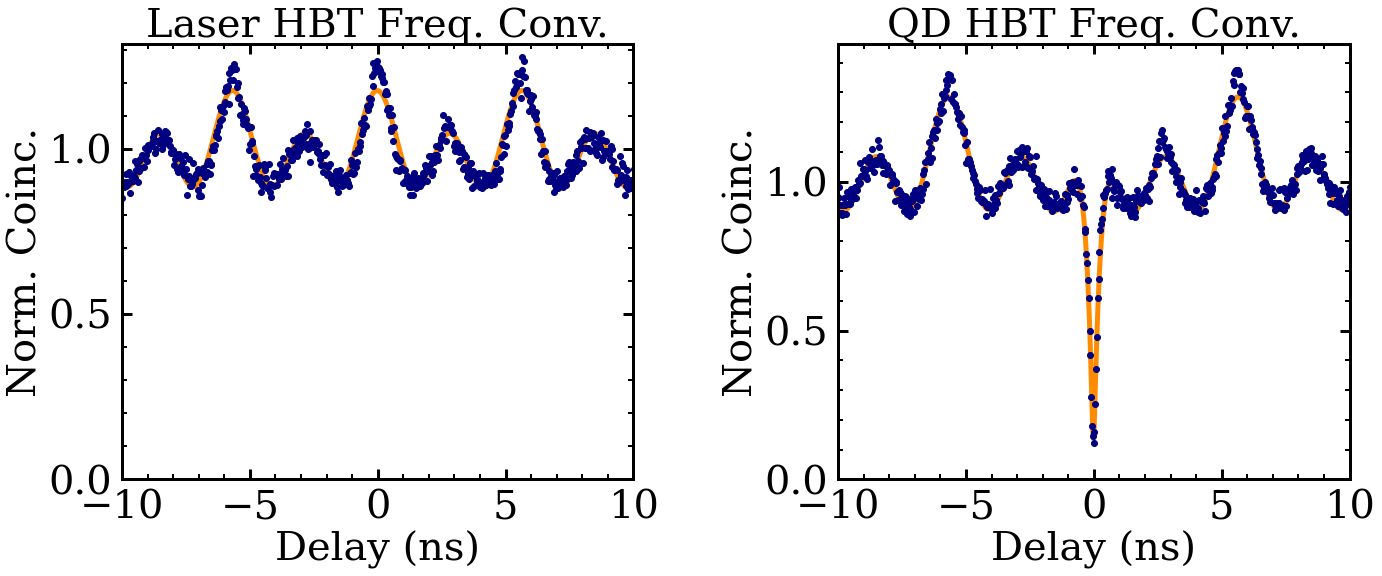

In [22]:


f = plt.figure(figsize=(22,8))
f.subplots_adjust(wspace=0.4)
ax = f.add_subplot(122)
ax1 = f.add_subplot(121)
# plot_fourier(ax1,delayhbt,coinhbt)

ax.plot(dummyx2,mod1.eval(res_osc.params,xdata=dummyx2),'-',color='darkorange',label='fit')
ax.plot(delayhbt[start1:end1],coinhbt[start1:end1],'o',color='navy',label='data')
ax.set_xlabel('Delay (ns)')
ax.set_ylabel('Norm. Coinc.')
# ax.text(0.5,0.55,r'$\rm g^{(2)}(0)=%.1f$'%(1-res_osc.params['bck'].value,))
# print (res_osc.fit_report())
ax.set_title('QD HBT Freq. Conv.')
ax.set_ylim(bottom=0)
ax.set_xlim([-10,10])

ax1.plot(dummyx2,Model(g2_nr_osc_laser).eval(res_osc_laser.params,xdata=dummyx2),'-',color='darkorange',label='fit')
ax1.plot(delayhbtlaser[start1:end1],coinhbtlaser[start1:end1],'o',color='navy',label='data')
ax1.set_xlabel('Delay (ns)')
ax1.set_ylabel('Norm. Coinc.')

ax1.set_title('Laser HBT Freq. Conv.')
ax1.set_ylim(bottom=0)
ax1.set_xlim([-10,10])
# f.savefig(filenamehbtlaser[:-4]+'_laser_dot_comparison.png',dpi=100,bbox_inches='tight',facecolor='white')

## Overlap the CW laser data with the Pulsed Laser data

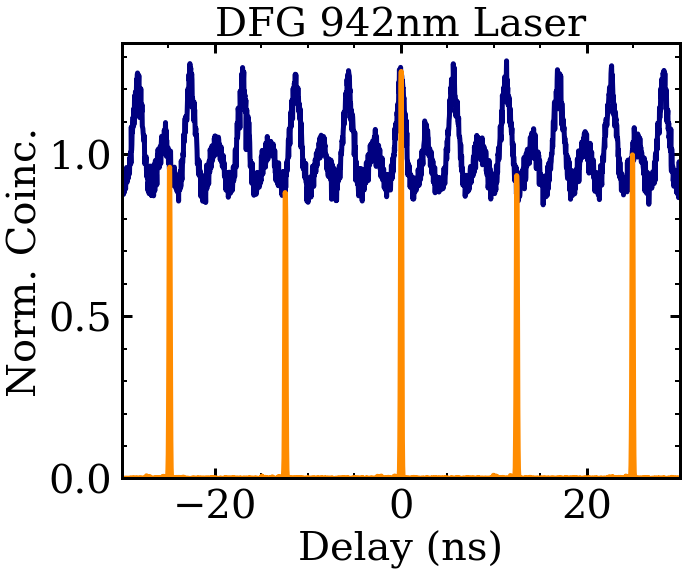

In [59]:
f = plt.figure()
ax =f.add_subplot(111)
ax.set_xlabel('Delay (ns)')
ax.set_ylabel('Norm. Coinc.')
ax.plot(delayhbtlaser[start1:end1],coinhbtlaser[start1:end1],'-',color='navy',label='CW ')
ax.plot(delayhbtpulsedlaser+0.035,coinhbtpulsedlaser/1240,color='darkorange',label='Pulsed')
ax.set_ylim(bottom=0)
ax.set_title('DFG 942nm Laser')
# ax.set_xscale('log')
ax.set_xlim([-30,30])
f.savefig(filenamehbtlaser[:-4]+'_cw_pulsed_comparison.png',dpi=100,bbox_inches='tight',facecolor='white')

In [350]:
# fit HOM data
def convoluted_g2_HOM_osc(xdata,ta,tb,xc,A,T1,T2,T3,amp, bck,delT,V0,sig,amp1,amp2,amp3,freq1,freq2,freq3):
    g2_data = hom_eqn(xdata,ta,tb,xc,A,T1,T2,T3,amp, bck,delT,V0)
    gau = np.exp(-((xdata-xc)**2/(2*sig**2)))/(sig*np.sqrt(2*np.pi))
    res = convolve(g2_data,gau)
    out = res
    out = out/np.mean(out[-int(len(xdata)/100):])
    return A*(out+ amp1*np.cos(2*np.pi*freq1*xdata) + amp2*np.cos(2*np.pi*freq2*xdata) +  amp3*np.cos(2*np.pi*freq3*xdata))

def hom_eqn_osc(xdata, ta, tb, xc, A, T1, T2, T3, amp, bck, delT, V0,amp1,amp2,amp3,freq1,freq2,freq3):
    return hom_eqn(xdata, ta, tb, xc, A, T1, T2, T3, amp, bck, delT, V0) + A*( amp1*np.cos(2*np.pi*freq1*xdata) + amp2*np.cos(2*np.pi*freq2*xdata) +  amp3*np.cos(2*np.pi*freq3*xdata))

def g2_hom_eqn_osc(xdata,Aper,Apar,ta,tb,t1,t11,T1,T2,T3,amp, bck,delT,V00,V0,sig,amp1,amp2,amp3,freq1,freq2,freq3):
    perp = convoluted_g2_HOM_osc(xdata,ta,tb,t1,Aper,T1,T2,T3,amp, bck,delT,V00,sig,amp1,amp2,amp3,freq1,freq2,freq3)
    par = convoluted_g2_HOM_osc(xdata,ta,tb,t11,Apar,T1,T2,T3,amp, bck,delT,V0,sig,amp1,amp2,amp3,freq1,freq2,freq3)
    return np.concatenate((par, perp))

def g2_hom_eqn_osc_dec(xdata,Aper,Apar,ta,tb,t1,t11,T1,T2,T3,amp, bck,delT,V00,V0,sig,amp1,amp2,amp3,freq1,freq2,freq3):
    perp = hom_eqn_osc(xdata,ta,tb,t1,Aper,T1,T2,T3,amp, bck,delT,V00,amp1,amp2,amp3,freq1,freq2,freq3)
    par = hom_eqn_osc(xdata,ta,tb,t11,Apar,T1,T2,T3,amp, bck,delT,V0,amp1,amp2,amp3,freq1,freq2,freq3)
    return np.concatenate((par, perp))


mod2 = Model(g2_hom_eqn_osc)
params = mod2.make_params(Aper=1,Apar=1,
                         ta=0.5,tb=0.5,
                         t1=0,t11=0,
                         T1 = res_osc.params['t1'].value ,T2=res_osc.params['t2'].value,T3=resultall.params['T3'].value,
                         amp = res_osc.params['amp'].value, bck=res_osc.params['bck'].value,
                         delT=12.5,V00 = 0.1,V0=1,sig=res_osc.params['sig'].value
                         ,amp1=res_osc.params['amp1'].value,amp2=res_osc.params['amp2'].value,amp3=res_osc.params['amp3'].value,
                         freq1=res_osc.params['freq1'].value,freq2=res_osc.params['freq2'].value,freq3=res_osc.params['freq3'].value)
params['Aper'].set(vary=True)
params['Apar'].set(vary=True)
params['ta'].set(vary=False)
params['tb'].set(vary=False)
# params['t1'].set(min=0,vary=not False)
params['t11'].set(expr='t1')
params['bck'].set(vary=False)
# params['bck'].set(vary=False)
params['sig'].set(min=1e-2,max=1,vary= False)
params['V00'].set(min=0,max=1,value = 0.31,vary= False)
params['V0'].set(min=1e-2,max=1,value = resultall.params['V0'].value,vary= False)
params['amp'].set(vary=False)
params['T1'].set(vary=False)
params['T2'].set(vary=False)
params['T3'].set(min=0,max=1,vary=False)
params['amp1'].set(vary=not False)
params['amp2'].set(vary=not False)
params['amp3'].set(vary=not False)
params['freq1'].set(vary=False)
params['freq2'].set(vary= False)
params['freq3'].set(vary= False)

_homdata = np.concatenate([coinhomp[start1:end1],coinhoms[start1:end1]])


res_hom_osc = mod2.fit(_homdata,params,xdata=delayhoms[start1:end1],weights=1/np.sqrt((_homdata)))

print (res_hom_osc.fit_report())

[[Model]]
    Model(g2_hom_eqn_osc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 62500
    # variables        = 7
    chi-square         = 64.0055621
    reduced chi-square = 0.00102420
    Akaike info crit   = -430232.990
    Bayesian info crit = -430169.690
[[Variables]]
    Aper:   1.04087248 +/- 1.8449e-04 (0.02%) (init = 1)
    Apar:   1.04974477 +/- 1.8528e-04 (0.02%) (init = 1)
    ta:     0.5 (fixed)
    tb:     0.5 (fixed)
    t1:    -0.02453233 +/- 8.4833e-04 (3.46%) (init = 0)
    t11:   -0.02453233 +/- 8.4833e-04 (3.46%) == 't1'
    T1:     0.2992748 (fixed)
    T2:     2527.312 (fixed)
    T3:     0.4839781 (fixed)
    amp:    0.03788905 (fixed)
    bck:    1.195417 (fixed)
    delT:   12.4385999 +/- 0.00519153 (0.04%) (init = 12.5)
    V00:    0.31 (fixed)
    V0:     0.738641 (fixed)
    sig:    0.03 (fixed)
    amp1:   0.07543612 +/- 1.7855e-04 (0.24%) (init = 0.09588465)
    amp2:   0.03363560 +/- 1.7739e-04 (

(-2.0, 2.0)

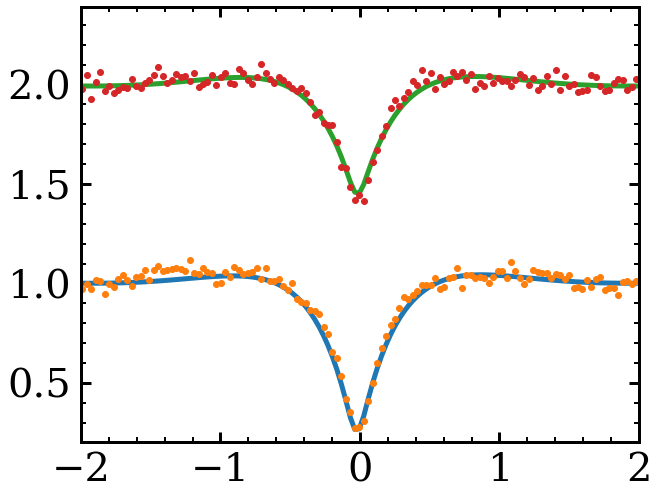

In [351]:


_homfit = mod2.eval(res_hom_osc.params,xdata=delayhoms[start1:end1])
homp = _homfit[len(delayhoms[start1:end1]):]
homs = _homfit[:len(delayhoms[start1:end1])]

dummyx = np.linspace(-30,30,10000)
_homfitdec = 0.98*Model(g2_hom_eqn_osc_dec).eval(res_hom_osc.params,xdata=dummyx)
hompdec = _homfitdec[len(dummyx):]
homsdec = _homfitdec[:len(dummyx)]

plt.plot(delayhoms[start1:end1],_homfit[:len(delayhoms[start1:end1])])
plt.plot(delayhoms[start1:end1],coinhoms[start1:end1],'o')

plt.plot(delayhoms[start1:end1],1+_homfit[len(delayhoms[start1:end1]):])
plt.plot(delayhoms[start1:end1],1+coinhomp[start1:end1],'o')



plt.xlim([-2,2])

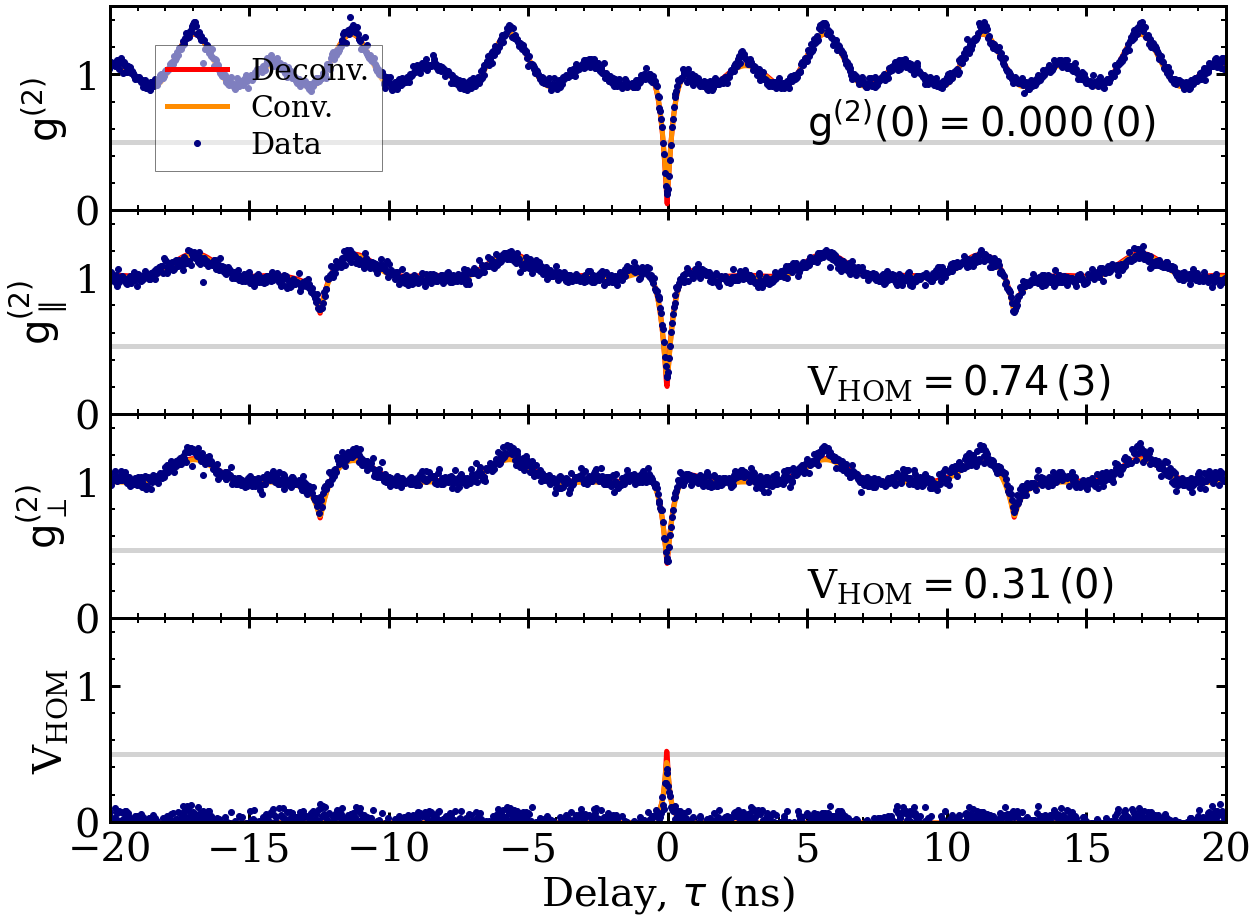

In [357]:
f = plt.figure(figsize=(20,15))
ax0 =f.add_subplot(411)
ax =f.add_subplot(412)
ax1 =f.add_subplot(413)
ax2 = f.add_subplot(414)
f.subplots_adjust(hspace=0, wspace=0)

start = find_nearest(delayhbt,-20)[0]
end = find_nearest(delayhbt,20)[0]
# vnorm = visibility_normalisation_constant(resultall.params,convoluted=True)



# ctw = np.sum(vhom[find_nearest(delays[start:end],-5)[0]:find_nearest(delays[start:end],5)[0]])*np.diff(delayp)[0]
# print ('CTW = %.3f ns'%ctw)

ax0.axhline(y=0.5,ls='-',color='lightgrey')
ax0.plot(dummyx2,0.97*Model(g2_nr_osc).eval(res_osc.params,xdata=dummyx2),'-',color='red',label='Deconv.')
# ax0.plot(delayhbt[start:end]-0.03*0,1.15*model.eval(resultdfg.params,xdata=delayhbt[start:end]),color='darkorange',label='Conv.')
# ax0.plot(delayhbt[start:end],model.eval(result.params,xdata=delayhbt[start:end]),color='darkorange',label='Conv.')
ax0.plot(dummyx2,mod1.eval(res_osc.params,xdata=dummyx2),'-',color='darkorange',label='Conv.')
ax0.plot(delayhbt[start:end],coinhbt[start:end],'o',color='navy',label='Data')
ax0.legend(loc='center left')


ax.axhline(y=0.5,ls='-',color='lightgrey')
ax1.axhline(y=0.5,ls='-',color='lightgrey')
ax2.axhline(y=0.5,ls='-',color='lightgrey')

ax.plot(dummyx+0.01,homsdec,ls='-',color='red')
ax.plot(delayhbt[start1:end1],homs,'-',color='darkorange')
ax.plot(delayhbt[start:end],coinhoms[start:end],'o',color='navy')

ax1.plot(dummyx+0.01,hompdec,ls='-',color='red')
ax1.plot(delayhbt[start1:end1],homp,'-',color='darkorange')
ax1.plot(delayhbt[start:end],coinhomp[start:end],'o',color='navy')

vhomdec =  (hompdec-homsdec)/hompdec/vnorm
vhomf = (homp-homs)/homp/vnorm
vhom = (coinhomp[start:end]-coinhoms[start:end])/coinhomp[start:end]/vnorm
ax2.plot(dummyx+0.01,vhomdec,ls='-',color='red')
ax2.plot(delayhbt[start1:end1],vhomf,'-',color='darkorange')
ax2.plot(delayhbt[start:end],vhom,'o',color='navy')

ax1.set_ylabel(r'$\rm g^{(2)}_\perp$')
ax0.set_ylabel(r'$\rm g^{(2)}$')
ax.set_ylabel(r'$\rm g^{(2)}_\parallel$')
ax2.set_ylabel(r'$\mathregular{V_{HOM}}$')
ax2.set_xlabel(r'Delay, $\tau$ (ns)')
ax.set_ylim([0,1.5])
ax0.set_ylim([0,1.5])
ax0.set_xticklabels([])
ax.set_xticklabels([])
ax1.set_xticklabels([])
ax1.set_ylim([0,1.5])
ax2.set_ylim([0,1.5])

_xlim = [-20,20]
# _xlim = [-2,2]
ax0.set_xlim(_xlim)
ax1.set_xlim(_xlim)
ax2.set_xlim(_xlim)
ax.set_xlim(_xlim)

# g20 = result.params['g20'].value
# g20_err = result.params['g20'].stderr

ax0.text(5,0.55,r'$\rm g^{(2)}(0)=%.3f\,(%.0f)$'%(g20,g20_err*1000))
# # ax2.text(-18,0.8,r'CTW = %.3f ns'%(ctw))
ax.text(5,0.15,r'$\mathregular{V_{HOM}}=%.2f\,(%.0f)$'%(resultall.params['V0'].value,resultall.params['V0'].stderr*1e2))
ax1.text(5,0.15,r'$\mathregular{V_{HOM}}=%.2f\,(%.0f)$'%(res_hom_osc.params['V00'].value,res_hom_osc.params['V00'].stderr*1e2))
f.savefig(filenamehbt[:-4]+'_summary_long.png',dpi=100,bbox_inches='tight',facecolor='white')
# f.savefig(filenamehbt[:-4]+'_summary_short.png',dpi=100,bbox_inches='tight',facecolor='white')